In [28]:
import pandas as pd 
import sklearn
import numpy as np
import xgboost as xgb
import plotly.express as px
from IPython.display import display, Image

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Models
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("part3_GrooverChallengeDataset.csv")

dfeatures = df.drop(['label'], axis=1)
dlabel = df[['label']]

n_features = len(dfeatures.columns)
n_labels = len(dlabel.drop_duplicates())
n_samples = len(dfeatures.values)

## Data Overview

In [3]:
# Look how balanced are the classes
dlabel.apply(pd.value_counts)

,label
blues,100
classical,100
country,100
disco,100
hiphop,100
jazz,100
metal,100
pop,100
reggae,100
rock,100


In [4]:
dfeatures = dfeatures.drop('length', axis=1)
dfeatures.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


<AxesSubplot:ylabel='Density'>

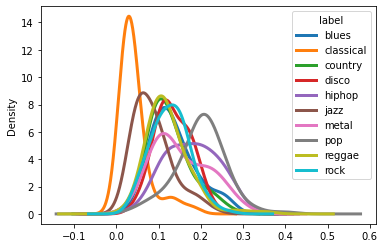

In [5]:
# Look how discriminative are the features
data_wide = df.pivot(columns = 'label',
                     values = 'rms_mean')
  
data_wide.plot.kde(figsize = (6, 4), linewidth = 3, bw_method=0.5)

<AxesSubplot:ylabel='Density'>

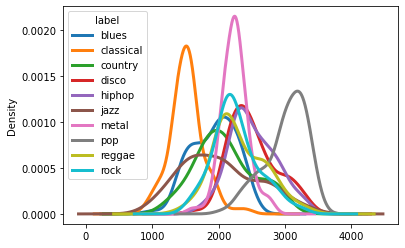

In [6]:
data_wide = df.pivot(columns = 'label',
                     values = 'spectral_bandwidth_mean')
data_wide.plot.kde(figsize = (6, 4),linewidth = 3)

In [8]:
# Look for correlated features : redundancy should be avoided
dfeatures.corr().unstack().sort_values().drop_duplicates()

spectral_centroid_mean   mfcc2_mean               -0.940180
rolloff_mean             mfcc2_mean               -0.934302
spectral_bandwidth_mean  mfcc2_mean               -0.896652
zero_crossing_rate_mean  mfcc2_mean               -0.760149
zero_crossing_rate_var   mfcc2_mean               -0.653520
                                                     ...   
harmony_var              rms_mean                  0.893898
spectral_bandwidth_mean  spectral_centroid_mean    0.904435
                         rolloff_mean              0.956189
rolloff_mean             spectral_centroid_mean    0.979637
chroma_stft_mean         chroma_stft_mean          1.000000
Length: 1597, dtype: float64

## Data Processing

#### Feature scaling

In [9]:
min_max_scaler = MinMaxScaler()
dfeatures_scaled = pd.DataFrame(min_max_scaler.fit_transform(dfeatures), columns=dfeatures.columns)

In [10]:
dfeatures_scaled.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,...,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,...,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,...,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405
3,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,0.171001,...,0.565151,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168
4,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,0.180228,...,0.383289,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836


In [31]:
features = dlabel.drop_duplicates()

pca = PCA(n_components=6)
components = pca.fit_transform(dfeatures_scaled)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df["label"]
)

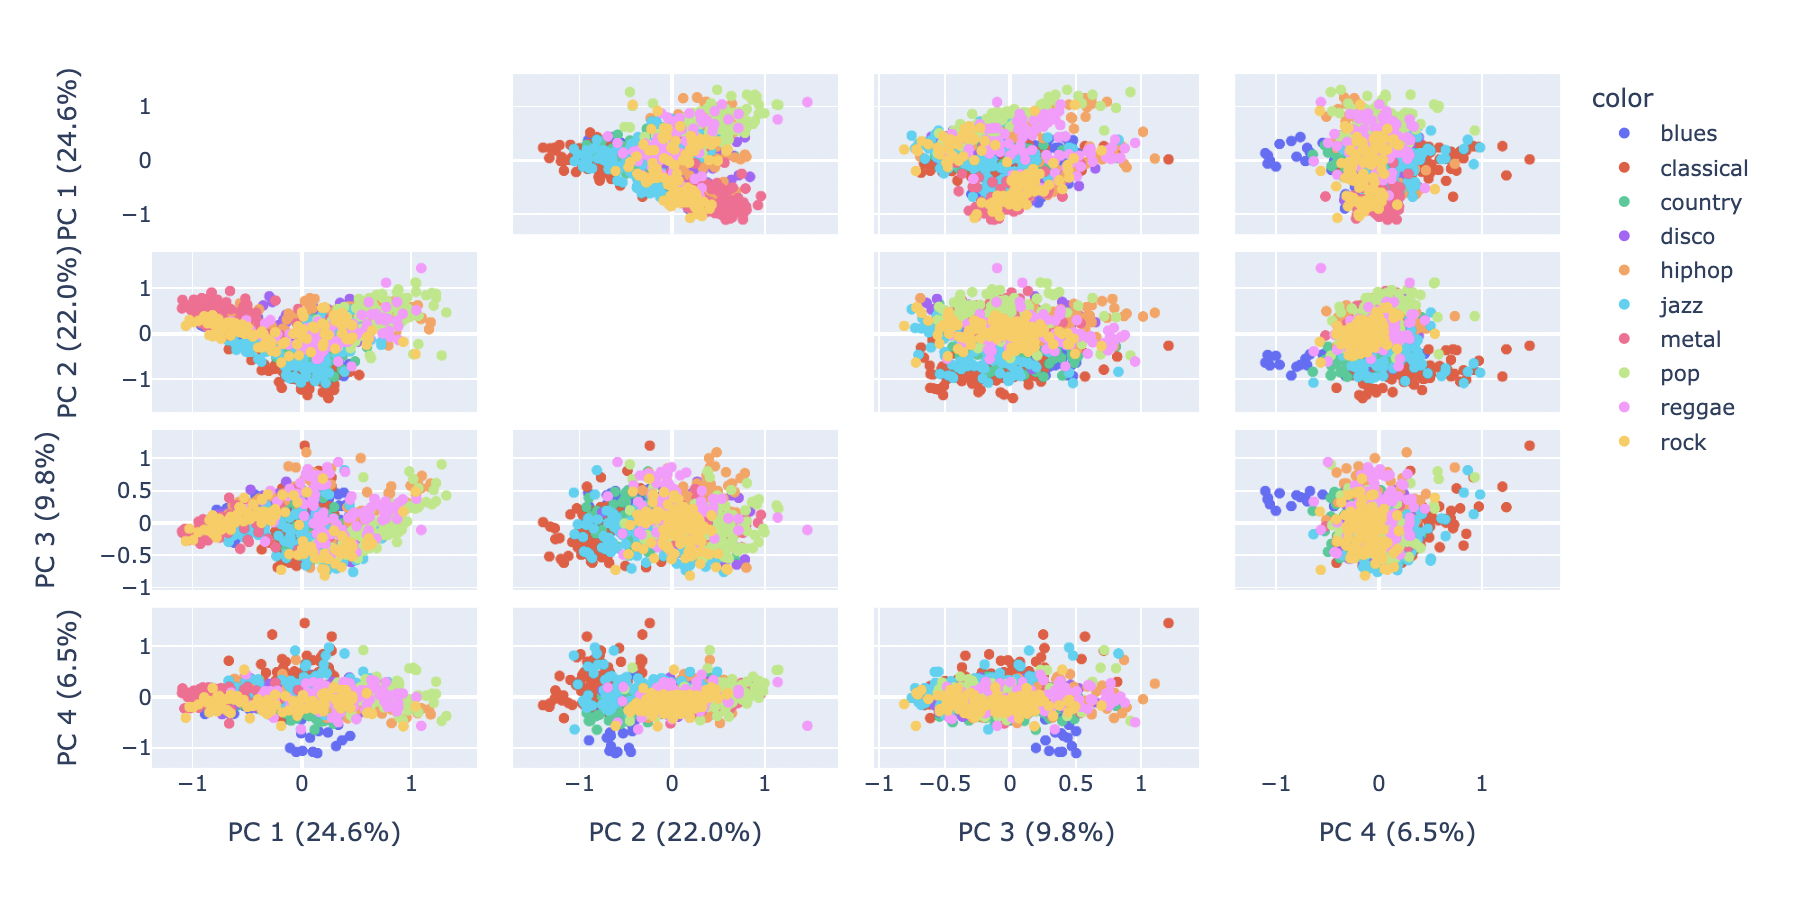

In [32]:
display(Image(filename='plots/scatter_matrix.png'))

#### Label encoding

In [12]:
labelencoder = LabelEncoder()
encoded_labels = labelencoder.fit_transform(dlabel['label'])

## Modeling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dfeatures_scaled, encoded_labels, test_size=0.33, random_state=30)

In the case of multiclass classification, standard performance indicators don't hold anymore. We will be using the **Macro F1-score** (MFS) which considers the performance of all classes.

Precision and Recall for each class are computed with the same formulas as in the binary setting. Macro-AveragePrecision and Macro-AverageRecall are then calculated using the arithmetic mean.

$$MacroF1Score = 2 * \frac{MacroAveragePrecision * MacroAverageRecall }{MacroAveragePrecision^{-1} + MacroAverageRecall^{-1}}$$ 

The obtained metric is calculated at a class level : Each class has the same importance. Thus, for high values of the MFS, the algorithm has good performance on all the classes, while low values indicate that all classes were poorly predicted.

By contrast, **Micro Averaging** is more sensitive to class imbalance. It is similar to accuracy and calculated at a  dataset level, where each unit has the same importance.

In [14]:
## Challenges :  

## Very small dataset 
## ** 100 tracks per genre
## ** Need more discriminative features

## Music genres influence each other. For instance, patterns found in rock might be found in jazz. 
## ** True boundaries can overlap, making the task more difficult. 
## ** High risk of overfitting and poor predictions: We try to describe 10 wide classes in a small space and few data points. 

#### K-Nearest Neighbors

In [15]:
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(X_train, y_train)
predicted_labels = KNN.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.6601639142809816

#### Non linear SVM

In [16]:
## Support Vector Machines use non-linear kernels to map data into a higher dimensional space and make 
## the data separable
## Good for small datasets 

In [17]:
rbf = svm.SVC(kernel='rbf', gamma=2, C=10, decision_function_shape='ovo')
rbf.fit(X_train, y_train)
predicted_labels = rbf.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.7431923920585054

#### Ensemble methods

In [18]:
# Decision trees are interesting as they learn non smooth boundaries
# Ensemble methods are also interesting to avoid overfitting

In [19]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(X_train, y_train)
predicted_labels = rf.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.6347398382591307

In [20]:
params = {'random_state': 1, 
         'learning_rate': 0.1, 
         'use_label_encoder': False,
         'objective': 'multi:softmax',
         'eval_metric': 'mlogloss'}

In [21]:
XGB = xgb.XGBClassifier(**params)
XGB.fit(X_train, y_train)
predicted_labels = XGB.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.7349463021596815

In [22]:
# One vs One is a heuristic mehtod based on the intuition that it is easier to distinguish between specific pairs
# classes instead of discrimating each class against the rest. 

# The same idea holds for music analysis.  
# For isntance, it might be easier to separate Jazz examples from Metal ones instead of comparing them
# to all other genres, based on their acousitc properties. 

In [23]:
OVO = OneVsOneClassifier(RandomForestClassifier(max_depth=5, random_state=0)).fit(X_train, y_train)
predicted_labels = OVO.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.680883874786754

#### Gaussian mixture models

In [24]:
# A gaussian mixture model will hardly perform well : hard to make a good estimation 
# of multivariate density functions with 100 points per class. 

In [25]:
NB = GaussianNB()
NB.fit(X_train, y_train)
predicted_labels = NB.predict(X_test)
f1_score(y_test, predicted_labels, average="macro")

0.5272157622395227